# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Logistic-Regression" data-toc-modified-id="Logistic-Regression-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Logistic Regression</a></div><div class="lev2 toc-item"><a href="#My-notes:" data-toc-modified-id="My-notes:-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>My notes:</a></div><div class="lev1 toc-item"><a href="#Load-and-Inspect-the-Data" data-toc-modified-id="Load-and-Inspect-the-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load and Inspect the Data</a></div><div class="lev2 toc-item"><a href="#Which-dimensions-to-choose-for-the-prediction?" data-toc-modified-id="Which-dimensions-to-choose-for-the-prediction?-21"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Which dimensions to choose for the prediction?</a></div><div class="lev1 toc-item"><a href="#Data-Preparation-(train,-test)" data-toc-modified-id="Data-Preparation-(train,-test)-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data Preparation (train, test)</a></div><div class="lev1 toc-item"><a href="#Manual-Implementation" data-toc-modified-id="Manual-Implementation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Manual Implementation</a></div><div class="lev2 toc-item"><a href="#Algorithm" data-toc-modified-id="Algorithm-41"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Algorithm</a></div><div class="lev2 toc-item"><a href="#Experiment" data-toc-modified-id="Experiment-42"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Experiment</a></div><div class="lev2 toc-item"><a href="#Analysis-of-parameters" data-toc-modified-id="Analysis-of-parameters-43"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Analysis of parameters</a></div><div class="lev2 toc-item"><a href="#Analysis-of-Convergence" data-toc-modified-id="Analysis-of-Convergence-44"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Analysis of Convergence</a></div><div class="lev1 toc-item"><a href="#Library-Implementations" data-toc-modified-id="Library-Implementations-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Library Implementations</a></div><div class="lev2 toc-item"><a href="#Statsmodel" data-toc-modified-id="Statsmodel-51"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Statsmodel</a></div><div class="lev2 toc-item"><a href="#SKLearn" data-toc-modified-id="SKLearn-52"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>SKLearn</a></div><div class="lev2 toc-item"><a href="#SciPy" data-toc-modified-id="SciPy-53"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>SciPy</a></div><div class="lev1 toc-item"><a href="#Sources:" data-toc-modified-id="Sources:-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Sources:</a></div><div class="lev2 toc-item"><a href="#Overviews:" data-toc-modified-id="Overviews:-61"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Overviews:</a></div><div class="lev2 toc-item"><a href="#Notebooks:" data-toc-modified-id="Notebooks:-62"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Notebooks:</a></div>

# Logistic Regression

## My notes:

* problem: y is not a continous value, but a discrete one, usually 0 or 1
* kind of a probability on a classification
* a sigmoid function represents the probabilty, whether a row is either 0 or 1
* 

# Load and Inspect the Data

For the experiments we will use the heart disease dataset (https://archive.ics.uci.edu/ml/datasets/heart+Disease)

In [176]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
df = pd.read_csv('./data/heart-disease.csv')
df['num_norm'] = df['num']
df['num_norm'] = df['num'].apply(lambda x: 1 if x>0 else 0)

# remove rows with NA values
df = df[(df['ca'] != '?') & (df['thal'] != '?')]

# transform nominal categorical columns into dummy variables
df = pd.concat([df, pd.get_dummies(df['cp'], prefix = 'cp')], axis=1)
df = pd.concat([df, pd.get_dummies(df['restecg'], prefix = 'restecg')], axis=1)
df = pd.concat([df, pd.get_dummies(df['slope'], prefix = 'slope')], axis=1)
df = pd.concat([df, pd.get_dummies(df['thal'], prefix = 'thal')], axis=1)

value_columns = list(df)
value_columns.remove('num_norm')
value_columns.remove('num')

columns = list(df)

## Which dimensions to choose for the prediction?

Available Columns after transformation

In [295]:
print('"' + '", "'.join(list(df)) + '"')

"age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num", "num_norm", "cp_1.0", "cp_2.0", "cp_3.0", "cp_4.0", "restecg_0.0", "restecg_1.0", "restecg_2.0", "slope_1.0", "slope_2.0", "slope_3.0", "thal_3.0", "thal_6.0", "thal_7.0"


To get an intution on the data, plot the different values of each dimension against the normalized value as stacked bars.

Maybe we can already identify a usable column to predict heart diseases.

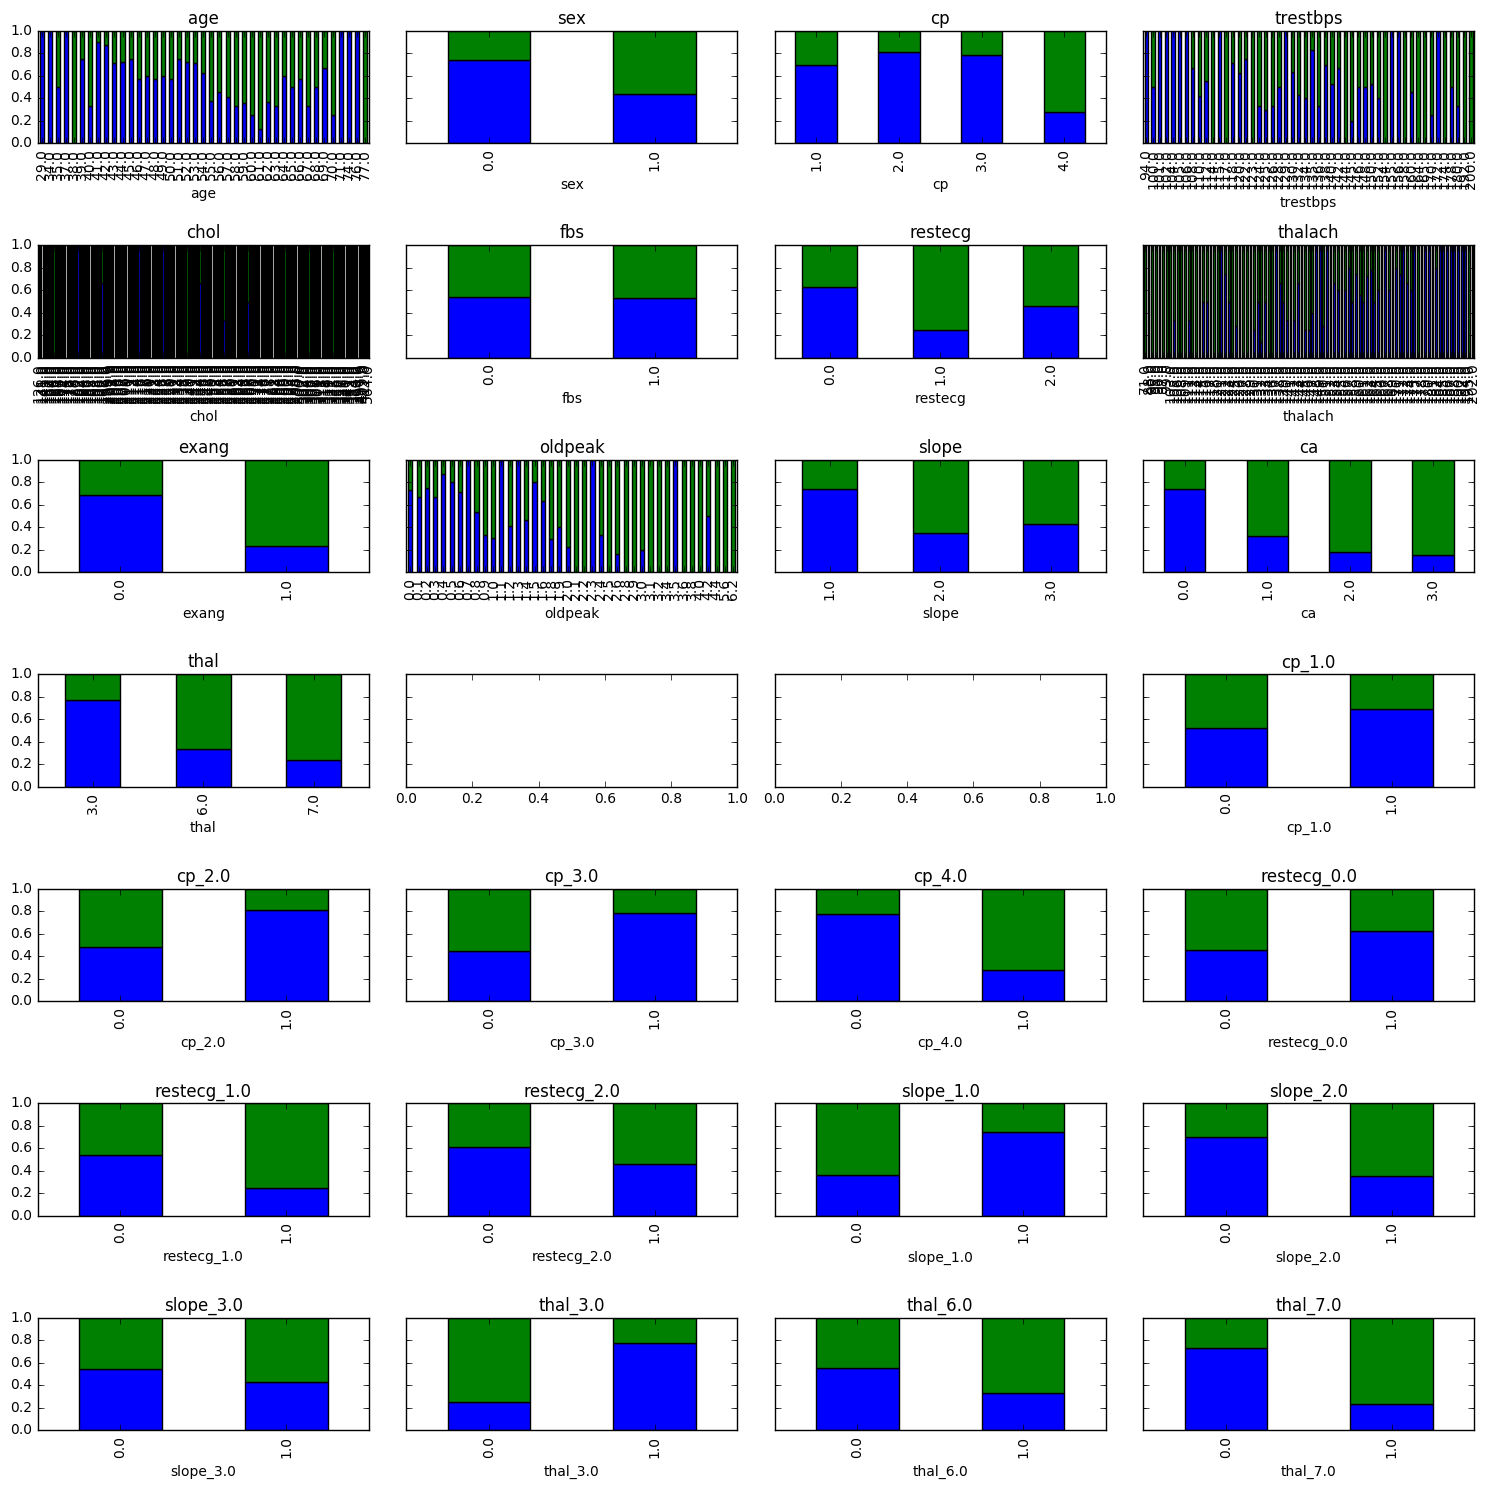

In [296]:
plt.close('all')
f, axarr = plt.subplots(7, int(len(list(df_filtered))/4)+1, sharey=True)
f.set_size_inches(15,15)

for i, cat in enumerate(list(df)):
    if cat == 'num' or cat == 'num_norm':
        continue
    risk = pd.crosstab(df[cat], df['num_norm'])
    risk.div(risk.sum(1).astype(int), axis=0).plot(ax= axarr[int(i/4), int(i%4)], kind='bar', stacked=True, legend=False, title = cat)
    
plt.tight_layout()

No dimension columns is expressive enough to be an obvious candidate for the logisitic regression.

Let's find some sets of expressive columns. Thanks to https://github.com/stephengo for the code.

First we will use the RandomizedLasso, second a linear regression.

In [304]:
from sklearn.linear_model import RandomizedLasso

rlasso = RandomizedLasso(alpha=0.01)
rlasso.fit(df[value_columns], df[['num_norm']].values.ravel())

stable_columns = sorted(zip(map(lambda x: round(x, 4), rlasso.scores_), columns), reverse=True)
print('The result of the RandomizedLasso:')
print(stable_columns)

print()
print('Columns with a score >0.1')
stable_columns = [x[1] for x in stable_columns if x[0] > 0.1]
print(stable_columns)

The result of the RandomizedLasso:
[(0.54000000000000004, 'cp_2.0'), (0.495, 'thal'), (0.48999999999999999, 'ca'), (0.34000000000000002, 'slope_2.0'), (0.28999999999999998, 'oldpeak'), (0.27500000000000002, 'thalach'), (0.185, 'exang'), (0.14499999999999999, 'thal_3.0'), (0.13500000000000001, 'cp'), (0.055, 'restecg_1.0'), (0.0050000000000000001, 'restecg_2.0'), (0.0, 'trestbps'), (0.0, 'slope_3.0'), (0.0, 'slope_1.0'), (0.0, 'slope'), (0.0, 'sex'), (0.0, 'restecg_0.0'), (0.0, 'restecg'), (0.0, 'num_norm'), (0.0, 'num'), (0.0, 'fbs'), (0.0, 'cp_4.0'), (0.0, 'cp_3.0'), (0.0, 'cp_1.0'), (0.0, 'chol'), (0.0, 'age')]

Columns with a score >0.1
['cp_2.0', 'thal', 'ca', 'slope_2.0', 'oldpeak', 'thalach', 'exang', 'thal_3.0', 'cp']


In [305]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

lr = LinearRegression()
rfe = RFE(lr, n_features_to_select=1)
rfe.fit(df[value_columns], df[['num_norm']].values.ravel())

rfe_columns = sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), columns))
print(rfe_columns)
print('The result of the LinearRegression:')

print()
print('Columns with a score <5')
rfe_columns = [x[1] for x in rfe_columns if x[0] < 5]
print(rfe_columns)

[(1, 'thal_3.0'), (2, 'exang'), (3, 'restecg_1.0'), (4, 'ca'), (5, 'cp_1.0'), (6, 'cp_4.0'), (7, 'sex'), (8, 'cp'), (9, 'slope_3.0'), (10, 'cp_3.0'), (11, 'thal'), (12, 'restecg_2.0'), (13, 'oldpeak'), (14, 'fbs'), (15, 'restecg_0.0'), (16, 'restecg'), (17, 'cp_2.0'), (18, 'num_norm'), (19, 'slope_1.0'), (20, 'slope'), (21, 'num'), (22, 'trestbps'), (23, 'slope_2.0'), (24, 'thalach'), (25, 'age'), (26, 'chol')]
The result of the LinearRegression:

Columns with a score <5
['thal_3.0', 'exang', 'restecg_1.0', 'ca']


# Data Preparation (train, test)

We will do our expirements on three different subsets of the data. So we will see the impact of the choose of columns.

In [244]:
from numpy import loadtxt, zeros, ones, array, linspace, logspace, vstack

# Xs
X = df[value_columns]
X_stable= df[stable_columns]
X_rfe= df[rfe_columns]
# Y
y_norm = df["num_norm"]
y = df['num']

# number of entries
n = y.size 
# Add a column of ones to X (interception data)
it = ones(shape=(n, len(list(X))+1 ) )
it[:, 1:] = X
X = it
it = ones(shape=(n, len(list(X_stable))+1 ) )
it[:, 1:] = X_stable
X_stable = it
it = ones(shape=(n, len(list(X_rfe))+1 ) )
it[:, 1:] = X_rfe
X_rfe = it

# Create a mask for selecting randomly 20% of data
msk = np.random.rand(len(y)) < 0.2

# Split x-values for into train and test datasets
X_test = X[msk]
X = X[~msk]
X_stable_test = X_stable[msk]
X_stable = X_stable[~msk]
X_rfe_test = X_rfe[msk]
X_rfe = X_rfe[~msk]

# Split y-values for media_value into train and test data
y_test = y[msk].copy()
y = y[~msk].copy()
y_norm_test = y_norm[msk].copy()
y_norm = y_norm[~msk].copy()

# Manual Implementation

Thanks to jdwittenauer for his implementation of logistic regression. 

https://nbviewer.jupyter.org/github/jdwittenauer/ipython-notebooks/blob/master/notebooks/ml/ML-Exercise2.ipynb

## Algorithm

The sigmoid function, which represents the propability of being 0 or 1.

In [226]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

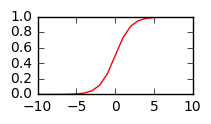

In [309]:
nums = np.arange(-10, 10, step=1)

fig, ax = plt.subplots(figsize=(2,1))
a = ax.plot(nums, sigmoid(nums), 'r')

The cost function

In [221]:
def cost(theta, X, y):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    first = np.multiply(-y, np.log(sigmoid(X * theta.T)))
    second = np.multiply((1 - y), np.log(1 - sigmoid(X * theta.T)))
    return np.sum(first - second) / (len(X))

Fill theta with zeros as default

In [285]:
theta = np.zeros(X.shape[1])
theta_stable= np.zeros(X_stable.shape[1])
theta_rfe = np.zeros(X_rfe.shape[1])

#theta = 0.1* np.random.randn(X.shape[1])
#theta_stable = 0.1* np.random.randn(X_stable.shape[1])
#theta_rfe = 0.1* np.random.randn(X_rfe.shape[1])

In [288]:
print(X.shape)
print(X_stable.shape)
print(X_rfe.shape)

print(y.shape)
print(y_norm.shape)

print(theta.shape)
print(theta_stable.shape)
print(theta_rfe.shape)

(243, 27)
(243, 10)
(243, 5)
(243,)
(243,)
(27,)
(10,)
(5,)


The costs for an unoptimized theta and the three different datasets.

In [286]:
print(cost(theta, X, y_norm))
print(cost(theta_stable, X_stable, y_norm))
print(cost(theta_rfe, X_rfe, y_norm))

168.434764876
168.434764876
168.434764876


The gradient descent algorithm for logistic regression

In [229]:
def gradient(theta, X, y):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    
    parameters = int(theta.ravel().shape[1])
    grad = np.zeros(parameters)
    
    error = sigmoid(X * theta.T) - y
    
    for i in range(parameters):
        term = np.multiply(error, X[:,i])
        grad[i] = np.sum(term) / len(X)
    
    return grad

The thetas after the first round of applying the gradient descent algorithm on the three different subsets.

In [274]:
gradient(theta, X, y_norm)

array([ -1.17000000e+02,  -6.36085185e+03,  -7.70370370e+01,
        -3.75074074e+02,  -1.52831852e+04,  -2.89346296e+04,
        -1.68518519e+01,  -1.16518519e+02,  -1.73848519e+04,
        -3.94814815e+01,  -1.31059259e+02,  -1.88259259e+02,
        -8.57037037e+01,  -5.54666667e+02,  -6.74074074e+00,
        -2.07037037e+01,  -3.12962963e+01,  -5.82592593e+01,
        -5.82592593e+01,  -9.62962963e-01,  -5.77777778e+01,
        -5.39259259e+01,  -5.48888889e+01,  -8.18518519e+00,
        -6.45185185e+01,  -6.25925926e+00,  -4.62222222e+01])

In [212]:
gradient(theta_stable, X_stable, y_norm)

array([   10.5       ,     1.77272727,    50.22727273,     6.95454545,
           4.68181818,  1578.09090909,    10.91363636,     3.13636364,
           5.68181818,    33.13636364])

In [213]:
gradient(theta_rfe, X_rfe, y_norm)

array([ 10.5       ,   5.68181818,   3.13636364,   0.09090909,   6.95454545])

## Experiment


For the optimization we will use optimization algorithms of scipy.

One can choose between different optimization algorithms.

Be aware: when using fmin_tnc the result is an array of arrays, so use result[0], when using fmin_bfgs use result.

In [319]:
import scipy.optimize as opt

In [316]:
#result = opt.fmin_tnc(func=cost, x0=theta, fprime=gradient, args=(X, y_norm))
result = opt.fmin_bfgs(cost, theta, fprime=gradient, args=(X, y_norm))
print(result)
print(cost(result, X, y_norm))

Optimization terminated successfully.
         Current function value: 168.268060
         Iterations: 25
         Function evaluations: 34
         Gradient evaluations: 34
[ -9.37973281e-03  -2.06479388e-12  -7.02091099e-10  -3.90822182e-03
   8.35503697e-13  -1.98984736e-12  -5.30877864e-10  -3.12657753e-03
   5.63498516e-12   4.37301478e-10   9.98572210e-11  -6.25315556e-03
   2.23439513e-10  -5.17502487e-03  -8.20726717e-03  -4.29904307e-03
  -3.90821801e-04   3.51739922e-03  -6.25315312e-03  -3.12658186e-03
   2.16656013e-09  -9.37973304e-03  -3.12657679e-03   3.12657702e-03
  -1.52016361e-02   3.23439592e-04   5.49846370e-03]
168.268060085


In [317]:
#result_stable = opt.fmin_tnc(func=cost, x0=theta_stable, fprime=gradient, args=(X_stable, y_norm))
result_stable = opt.fmin_bfgs(cost, theta_stable, fprime=gradient, args=(X_stable, y_norm))
print(result_stable)
print(cost(result_stable, X_stable , y_norm))

Optimization terminated successfully.
         Current function value: 168.268060
         Iterations: 20
         Function evaluations: 27
         Gradient evaluations: 27
[ -7.41080028e-02  -5.08273319e-10   4.47159535e-09  -1.39680865e-10
   2.47864750e-09  -2.23257567e-11  -3.28825641e-10  -6.23697358e-09
   1.70780461e-08   1.20084818e-09]
168.268060085


In [320]:
#result_rfe = opt.fmin_tnc(func=cost, x0=theta_rfe, fprime=gradient, args=(X_rfe, y_norm))
result_rfe = opt.fmin_bfgs(cost, theta_rfe, fprime=gradient, args=(X_rfe, y_norm))

print(result_rfe)
print(cost(result_rfe, X_rfe , y_norm))

Optimization terminated successfully.
         Current function value: 168.268060
         Iterations: 8
         Function evaluations: 13
         Gradient evaluations: 13
[ -7.41079539e-02   1.77519375e-08   1.64187546e-08  -7.19493387e-08
   1.83461308e-08]
168.268060085


In [233]:
def predict(theta, X):
    probability = sigmoid(X * theta.T)
    return [1 if x >= 0.5 else 0 for x in probability]

In [332]:
def accuracy(theta, X, y):
    theta_min = np.matrix(theta)
    predictions = predict(theta_min, X)
    correct = [1 if ((a == 1 and b == 1) or (a == 0 and b == 0)) else 0 for (a, b) in zip(predictions, y)]
    accuracy = (sum(map(int, correct)) % len(correct))
    print(theta_min)
    print('\taccuracy = {0}%'.format(accuracy))
    print('\tMAE: ', metrics.mean_absolute_error(y, predictions))
    print('\tMSE: ', metrics.mean_squared_error(y, predictions))
    print('\tRMSE: ', np.sqrt(metrics.mean_squared_error(y, predictions)))
    print()

In [333]:
accuracy(result, X_test, y_norm_test)
accuracy(result_stable, X_stable_test, y_norm_test)
accuracy(result_rfe, X_rfe_test, y_norm_test)


[[ -9.37973281e-03  -2.06479388e-12  -7.02091099e-10  -3.90822182e-03
    8.35503697e-13  -1.98984736e-12  -5.30877864e-10  -3.12657753e-03
    5.63498516e-12   4.37301478e-10   9.98572210e-11  -6.25315556e-03
    2.23439513e-10  -5.17502487e-03  -8.20726717e-03  -4.29904307e-03
   -3.90821801e-04   3.51739922e-03  -6.25315312e-03  -3.12658186e-03
    2.16656013e-09  -9.37973304e-03  -3.12657679e-03   3.12657702e-03
   -1.52016361e-02   3.23439592e-04   5.49846370e-03]]
	accuracy = 34%
	MAE:  0.37037037037
	MSE:  0.37037037037
	RMSE:  0.60858061945

[[ -7.41080028e-02  -5.08273319e-10   4.47159535e-09  -1.39680865e-10
    2.47864750e-09  -2.23257567e-11  -3.28825641e-10  -6.23697358e-09
    1.70780461e-08   1.20084818e-09]]
	accuracy = 34%
	MAE:  0.37037037037
	MSE:  0.37037037037
	RMSE:  0.60858061945

[[ -7.41079539e-02   1.77519375e-08   1.64187546e-08  -7.19493387e-08
    1.83461308e-08]]
	accuracy = 34%
	MAE:  0.37037037037
	MSE:  0.37037037037
	RMSE:  0.60858061945



## Analysis of parameters

## Analysis of Convergence

# Library Implementations

## Statsmodel

In [ ]:
from statsmodels.discrete.discrete_model import Logit
from patsy import dmatrices
import statsmodels.discrete.discrete_model as sm

In [339]:
logit = sm.Logit(y_norm, X)
fit = logit.fit(method='bfgs')

#print('Intercept + Coefficients: ', fit.params)
#print('P-Values: ', fit.pvalues)
#print('Conf. Interval: ', fit.conf_int())

print('')
print(cost(fit.params, X , y_norm))
accuracy(fit.params, X, y_norm)
accuracy(fit.params, X_test, y_norm_test)

         Current function value: 0.274102
         Iterations: 35
         Function evaluations: 39
         Gradient evaluations: 39

402.9676146
[[ -3.74366834e-01  -1.14091466e-02   1.81695348e+00   4.58428661e-01
    2.63937749e-02   1.78760050e-03  -8.85147776e-01   1.16559521e-01
   -4.40099747e-02   7.16464482e-01   3.10725756e-01  -3.11866990e-01
    1.21329622e+00   3.98134414e-02  -8.76917883e-01   8.31129232e-01
   -9.87400812e-01   6.58822629e-01  -4.61108240e-01   5.69232916e-02
    2.98181148e-02  -6.67883138e-01   5.24532764e-01  -2.31016460e-01
   -4.04994823e-01  -1.04040199e+00   1.07102998e+00]]
	accuracy = 220%
	MAE:  0.0946502057613
	MSE:  0.0946502057613
	RMSE:  0.307652735664

[[ -3.74366834e-01  -1.14091466e-02   1.81695348e+00   4.58428661e-01
    2.63937749e-02   1.78760050e-03  -8.85147776e-01   1.16559521e-01
   -4.40099747e-02   7.16464482e-01   3.10725756e-01  -3.11866990e-01
    1.21329622e+00   3.98134414e-02  -8.76917883e-01   8.31129232e-01
   -9.87400

/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [335]:
logit = sm.Logit(y_norm, X_stable)
fit = logit.fit(method='bfgs')

#print('Intercept + Coefficients: ', fit.params)
#print('P-Values: ', fit.pvalues)
#print('Conf. Interval: ', fit.conf_int())

print('')
print(cost(fit.params, X_stable , y_norm))
accuracy(fit.params, X_stable, y_norm)
accuracy(fit.params, X_stable_test, y_norm_test)


         Current function value: 0.328091
         Iterations: 35
         Function evaluations: 39
         Gradient evaluations: 39

336.575546095
[[-0.75070007  1.49410806  0.29007702  1.03572448  0.35155552 -0.03318717
   0.45540873  0.87280568 -0.8409484   0.91293829]]
	accuracy = 211%
	MAE:  0.131687242798
	MSE:  0.131687242798
	RMSE:  0.362887369301

[[-0.75070007  1.49410806  0.29007702  1.03572448  0.35155552 -0.03318717
   0.45540873  0.87280568 -0.8409484   0.91293829]]
	accuracy = 40%
	MAE:  0.259259259259
	MSE:  0.259259259259
	RMSE:  0.509175077217



/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [247]:
logit = sm.Logit(y_norm, X_rfe)
fit = logit.fit(method='bfgs')

#print('Intercept + Coefficients: ', fit.params)
#print('P-Values: ', fit.pvalues)
#print('Conf. Interval: ', fit.conf_int())

print('')
print(cost(fit.params, X_rfe , y_norm))
accuracy(fit.params, X_rfe, y_norm)
accuracy(fit.params, X_rfe_test, y_norm_test)

         Current function value: 0.391027
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36

289.645359808
accuracy = 208%
accuracy = 41%

MAE:  0.700270815259
MSE:  1.18875464705
RMSE:  1.09030025546


/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


## SKLearn

In [253]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score

In [281]:
model = LogisticRegression(C=1e5)

fit = model.fit(X.astype('float'), y)

#print('Coefficients a1, a2: ', fit.coef_)
#print('Intercept a0: ', fit.intercept_)
#print('R-Squared: ',fit.score(X_test, y_test))

print('')
print(cost(fit.coef_[4], X , y_norm))
accuracy(fit.coef_[4], X, y_norm)
accuracy(fit.coef_[4], X_test, y_norm_test)


747.524123696
accuracy = 166%
accuracy = 32%

MAE:  0.740740740741
MSE:  1.7037037037
RMSE:  1.30526001383


In [282]:
model = LogisticRegression(C=1e5)

fit = model.fit(X_stable.astype('float'), y)

#print('Coefficients a1, a2: ', fit.coef_)
#print('Intercept a0: ', fit.intercept_)
#print('R-Squared: ',fit.score(X_test, y_test))

print('')
print(cost(fit.coef_[4], X_stable , y_norm))
accuracy(fit.coef_[4], X_stable, y_norm)
accuracy(fit.coef_[4], X_stable_test, y_norm_test)


616.633750995
accuracy = 185%
accuracy = 31%

MAE:  0.592592592593
MSE:  1.11111111111
RMSE:  1.05409255339


In [280]:
model = LogisticRegression(C=1e5)

fit = model.fit(X_rfe, y)

print('Coefficients a1, a2: ', fit.coef_)
#print('Intercept a0: ', fit.intercept_)
#print('R-Squared: ',fit.score(X_test, y_test))

print('')
print(cost(fit.coef_[4], X_rfe , y_norm))
accuracy(fit.coef_[4], X_rfe, y_norm)
accuracy(fit.coef_[4], X_rfe_test, y_norm_test)

Coefficients a1, a2:  [[ 0.11979767  2.30272814 -1.89663027 -5.06083665 -1.21671612]
 [-0.66827606 -0.73229463  0.72780948 -7.16320939 -0.09297522]
 [-1.03053134 -1.46264307  0.44566253 -7.54492106  0.50647783]
 [-1.33653413 -1.35256353  1.24646564  0.66915985  0.69033085]
 [-2.10920839 -0.83150765  0.11330399  2.32169578  0.92001082]]

273.649476866
accuracy = 135%
accuracy = 36%

MAE:  0.592592592593
MSE:  1.11111111111
RMSE:  1.05409255339


## SciPy

see Manual Implementation

# Sources:

## Overviews:

http://wiki.fast.ai/index.php/Logistic_Regression

http://www.holehouse.org/mlclass/06_Logistic_Regression.html

https://www.cs.cmu.edu/~ninamf/courses/601sp15/lectures.shtml

https://aimotion.blogspot.de/2011/11/machine-learning-with-python-logistic.html

## Notebooks:

https://github.com/stephengo/heart-disease-model/blob/master/LogRegression.ipynb

https://github.com/LucDemortier/HeartDiseaseStudy/blob/master/HeartDiseaseProject.ipynb

https://nbviewer.jupyter.org/github/jdwittenauer/ipython-notebooks/blob/master/notebooks/ml/ML-Exercise2.ipynb

https://gist.github.com/vietjtnguyen/6655020 - for the manual part